# **Disusun Oleh :**
# I Made Ariana : 22.11.4570
# Ahmad Gilang Permana : 22.11.4603
# Yulian        : 22.11.4605

# **BIG DATA & Analytics Prediksi Popularitas Game di Platform terbaru**

In [ ]:
!pip install pyspark

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Mengakses file yang ada di Google Drive (misal di folder 'My Drive')
file_path = '/content/drive/My Drive/dataset-ai/all_video_games(cleaned).csv'
data = pd.read_csv(file_path)
print(data.head())

                           Title Release Date                    Developer  \
0                Ziggurat (2012)    2/17/2012  Action Button Entertainment   
1                      4X4 EVO 2   11/15/2001             Terminal Reality   
2                MotoGP 2 (2001)    1/22/2002                        Namco   
3                       Gothic 3   11/14/2006                Piranha Bytes   
4  Siege Survival: Gloria Victis    5/18/2021               FishTankStudio   

         Publisher           Genres        Product Rating  User Score  \
0     Freshuu Inc.           Action                   NaN         6.9   
1        Gathering  Auto Racing Sim  Rated E For Everyone         NaN   
2            Namco  Auto Racing Sim  Rated E For Everyone         5.8   
3            Aspyr      Western RPG      Rated T For Teen         7.5   
4  Black Eye Games              RPG                   NaN         6.5   

   User Ratings Count                                     Platforms Info  
0                

In [6]:
print(data.dtypes)

Title                  object
Release Date           object
Developer              object
Publisher              object
Genres                 object
Product Rating         object
User Score            float64
User Ratings Count    float64
Platforms Info         object
dtype: object


## **Pre-Processing**

In [7]:
# Melihat informasi awal dataset
print(data.info())

# Melihat jumlah missing values pada setiap kolom
print(data.isnull().sum())

# Statistik deskriptif dataset
print(data.describe())

# Handling missing values
# 1. Mengisi missing values pada kolom numerik dengan median
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

# 2. Mengisi missing values pada kolom kategorikal dengan modus
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

# Verifikasi apakah masih ada missing values
print(data.isnull().sum())

# Konversi dataframe Pandas ke dataframe PySpark
spark = SparkSession.builder.appName("MissingValueHandling").getOrCreate()
spark_data = spark.createDataFrame(data)

# Menampilkan schema PySpark dataframe
spark_data.printSchema()

# Menyimpan kembali data yang telah diproses
output_path = "/content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv"
data.to_csv(output_path, index=False)
print(f"Data setelah preprocessing telah disimpan ke: {output_path}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14055 entries, 0 to 14054
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               14034 non-null  object 
 1   Release Date        13991 non-null  object 
 2   Developer           13917 non-null  object 
 3   Publisher           13917 non-null  object 
 4   Genres              14034 non-null  object 
 5   Product Rating      11005 non-null  object 
 6   User Score          11714 non-null  float64
 7   User Ratings Count  11299 non-null  float64
 8   Platforms Info      14055 non-null  object 
dtypes: float64(2), object(7)
memory usage: 988.4+ KB
None
Title                   21
Release Date            64
Developer              138
Publisher              138
Genres                  21
Product Rating        3050
User Score            2341
User Ratings Count    2756
Platforms Info           0
dtype: int64
         User Score  User Ratings Coun

<ipython-input-7-2e0186da175c>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-7-2e0186da175c>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

root
 |-- Title: string (nullable = true)
 |-- Release Date: string (nullable = true)
 |-- Developer: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Product Rating: string (nullable = true)
 |-- User Score: double (nullable = true)
 |-- User Ratings Count: double (nullable = true)
 |-- Platforms Info: string (nullable = true)

Data setelah preprocessing telah disimpan ke: /content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv


In [21]:
#merubah data product rating string ke numerik agar mudah di baca dan menghasilkan data Gradient Boosted Tree Regressor (Spark MLlib)

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Membuat session Spark
spark = SparkSession.builder.appName("GamePopularityEstimation_GBT").getOrCreate()

# Memuat data dari CSV yang telah diproses sebelumnya
file_path = "/content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv"
spark_data = spark.read.csv(file_path, header=True, inferSchema=True)

# Mengonversi rating string menjadi angka
spark_data = spark_data.withColumn(
    'Product Rating Numeric',
    when(col('Product Rating') == 'Rated E For Everyone', 1)
    .when(col('Product Rating') == 'Rated T For Teen', 2)
    .when(col('Product Rating') == 'Rated M For Mature', 3)
    .when(col('Product Rating') == 'Rated E +10 For Everyone +10', 1)  # Bisa menyesuaikan angka jika perlu
    .otherwise(0)  # Untuk nilai yang tidak dikenali, beri nilai default
)

# Menampilkan beberapa data setelah konversi
spark_data.select('Product Rating', 'Product Rating Numeric').show(5)

+--------------------+----------------------+
|      Product Rating|Product Rating Numeric|
+--------------------+----------------------+
|    Rated T For Teen|                     2|
|Rated E For Everyone|                     1|
|Rated E For Everyone|                     1|
|    Rated T For Teen|                     2|
|    Rated T For Teen|                     2|
+--------------------+----------------------+
only showing top 5 rows



Summary Statistik:
         User Score  User Ratings Count
count  14055.000000        14055.000000
mean       6.945678          204.142583
std        1.276059         1658.960547
min        0.300000            5.000000
25%        6.400000           17.000000
50%        7.200000           34.000000
75%        7.700000           81.000000
max       10.000000       163419.000000


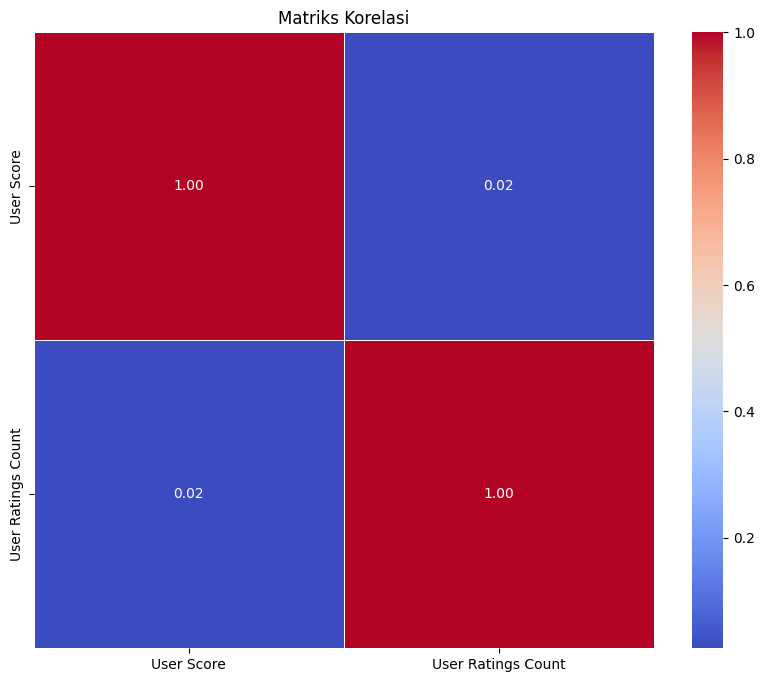

In [8]:
# Menampilkan summary statistik untuk kolom numerik
summary = data.describe()
print("Summary Statistik:")
print(summary)

# Menyeleksi hanya kolom numerik
data_numerik = data.select_dtypes(include=['float64', 'int64'])

# Menampilkan matriks korelasi
correlation_matrix = data_numerik.corr()

# Menampilkan matriks korelasi dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi')
plt.show()

## **Implementasi EDA**

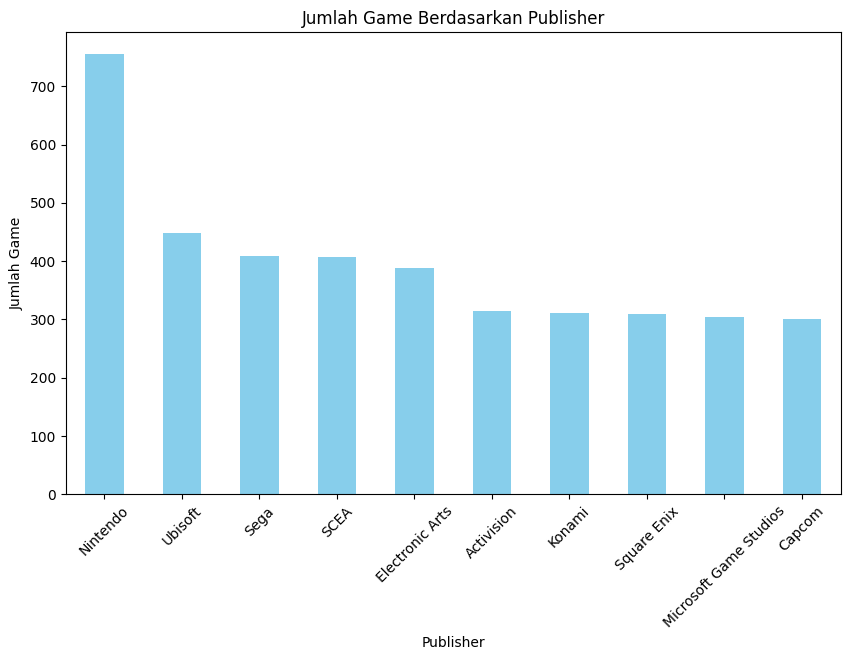

In [9]:
# 1. Bar Chart: Jumlah game berdasarkan Publisher
plt.figure(figsize=(10, 6))
publisher_counts = data['Publisher'].value_counts().head(10)  # Mengambil 10 Publisher teratas
publisher_counts.plot(kind='bar', color='skyblue')
plt.title('Jumlah Game Berdasarkan Publisher')
plt.xlabel('Publisher')
plt.ylabel('Jumlah Game')
plt.xticks(rotation=45)
plt.show()

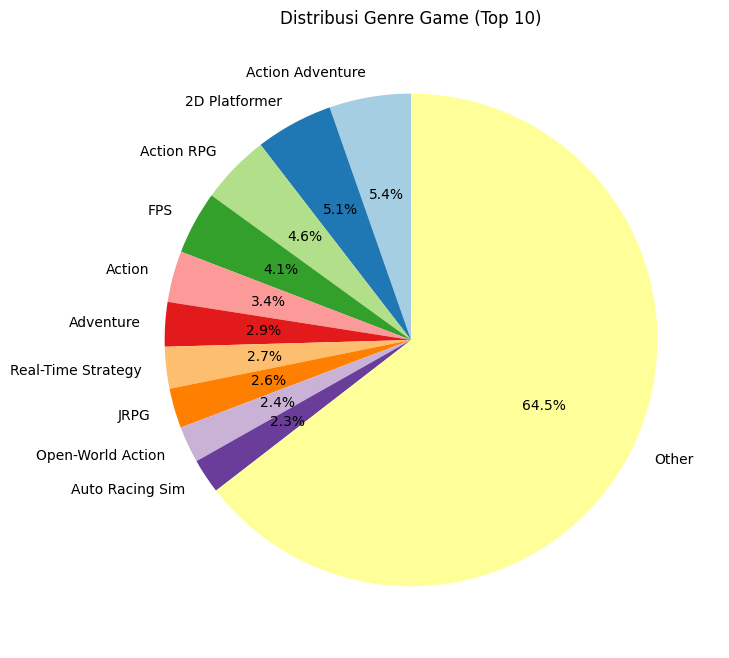

In [10]:
# 2. Pie Chart: Distribusi Genre Game
# Menampilkan genre dengan persentase terbesar
genre_counts = data['Genres'].value_counts()

# Menampilkan genre dengan persentase terbesar
top_genres = genre_counts.head(10)  # Menampilkan 10 genre teratas
other_genres = genre_counts.tail(len(genre_counts) - 10).sum()  # Gabungkan genre lainnya

# Menggabungkan genre teratas dengan genre lainnya
top_genres = pd.concat([top_genres, pd.Series({'Other': other_genres})])

# Pie chart yang disederhanakan
plt.figure(figsize=(8, 8))
top_genres.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribusi Genre Game (Top 10)')
plt.ylabel('')  # Menghapus label 'Genres'
plt.show()

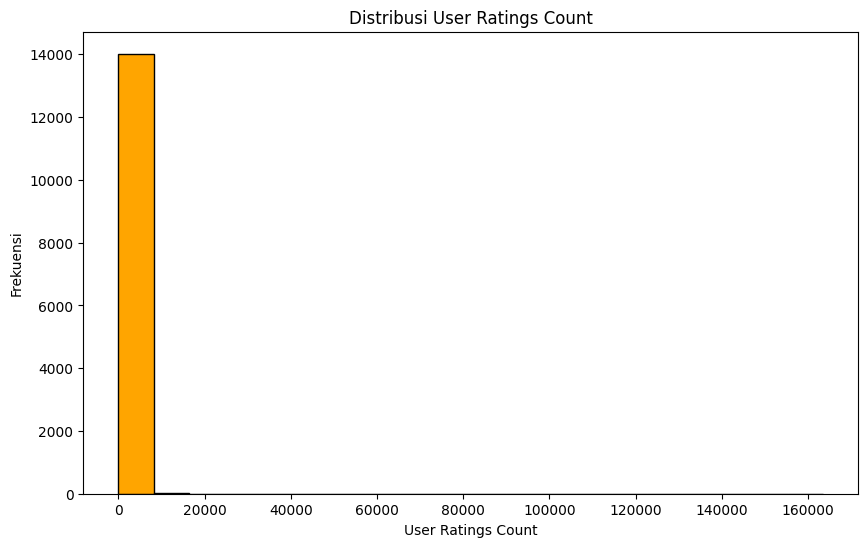

In [11]:
# 3. Histogram: Distribusi User Ratings Count
plt.figure(figsize=(10, 6))
data['User Ratings Count'].dropna().plot(kind='hist', bins=20, color='orange', edgecolor='black')
plt.title('Distribusi User Ratings Count')
plt.xlabel('User Ratings Count')
plt.ylabel('Frekuensi')
plt.show()

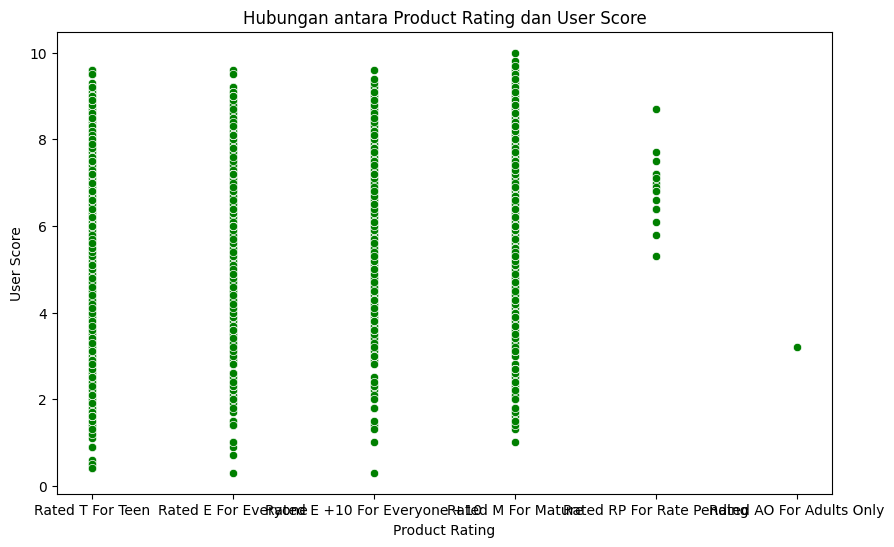

In [12]:
# 4. Scatter Plot: Hubungan antara Product Rating dan User Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Product Rating', y='User Score', color='green')
plt.title('Hubungan antara Product Rating dan User Score')
plt.xlabel('Product Rating')
plt.ylabel('User Score')
plt.show()

## **Implementasi Model**

+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|               Title|Release Date|           Developer|      Publisher|         Genres|      Product Rating|User Score|User Ratings Count|      Platforms Info|
+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|     Ziggurat (2012)|   2/17/2012|Action Button Ent...|   Freshuu Inc.|         Action|    Rated T For Teen|       6.9|              14.0|[{'Platform': 'iO...|
|           4X4 EVO 2|  11/15/2001|    Terminal Reality|      Gathering|Auto Racing Sim|Rated E For Everyone|       7.2|              34.0|[{'Platform': 'Xb...|
|     MotoGP 2 (2001)|   1/22/2002|               Namco|          Namco|Auto Racing Sim|Rated E For Everyone|       5.8|              34.0|[{'Platform': 'Pl...|
|            Gothic 3|  11/14/2006

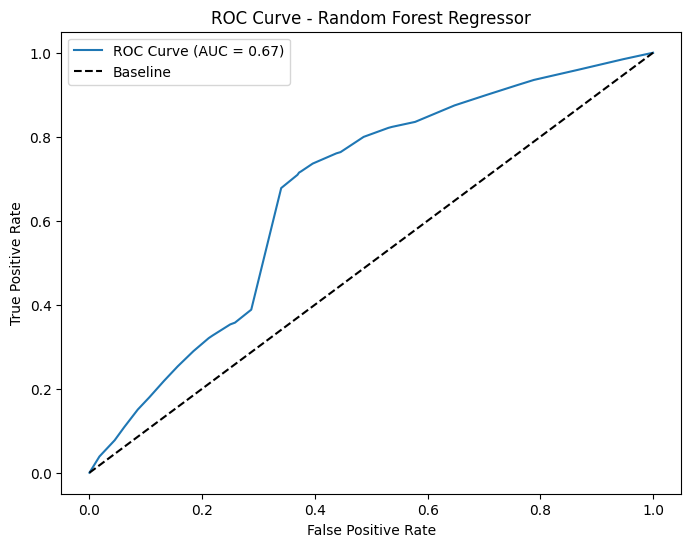

Model telah disimpan ke: /content/drive/My Drive/dataset-ai/random_forest_model


In [14]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

# Membuat sesi Spark
spark = SparkSession.builder.appName("GamePopularityEstimation").getOrCreate()

# Load dataset yang telah diproses (pastikan path sesuai)
file_path = "/content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Menampilkan beberapa baris data
data.show(5)

# Mengecek schema data untuk memastikan tipe datanya sesuai
data.printSchema()

# Memilih fitur (user_score dan user_rating_count) dan target (popularitas)
target_col = "User Score"
features = ['User Ratings Count']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Memisahkan dataset menjadi training dan testing set (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Inisialisasi Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, numTrees=100, maxDepth=5, seed=42)

# Melatih model
rf_model = rf.fit(train_data)

# Membuat prediksi pada testing set
predictions = rf_model.transform(test_data)

# Menampilkan beberapa prediksi
predictions.select("features", target_col, "prediction").show(5)

# Evaluasi regresi (RMSE dan R²)
rmse_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")

rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

# Evaluasi klasifikasi
# Konversi data ke Pandas untuk evaluasi tambahan
pandas_predictions = predictions.select("User Score", "prediction").toPandas()
threshold = 7.0  # Contoh threshold untuk binarisasi
y_true = (pandas_predictions["User Score"] > threshold).astype(int)
y_pred = (pandas_predictions["prediction"] > threshold).astype(int)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, pandas_predictions["prediction"])

print(f"Akurasi: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC (ROC Curve): {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, pandas_predictions["prediction"])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest Regressor")
plt.legend()
plt.show()

# Menyimpan model
model_path = "/content/drive/My Drive/dataset-ai/random_forest_model"
rf_model.save(model_path)
print(f"Model telah disimpan ke: {model_path}")


+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|               Title|Release Date|           Developer|      Publisher|         Genres|      Product Rating|User Score|User Ratings Count|      Platforms Info|
+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|     Ziggurat (2012)|   2/17/2012|Action Button Ent...|   Freshuu Inc.|         Action|    Rated T For Teen|       6.9|              14.0|[{'Platform': 'iO...|
|           4X4 EVO 2|  11/15/2001|    Terminal Reality|      Gathering|Auto Racing Sim|Rated E For Everyone|       7.2|              34.0|[{'Platform': 'Xb...|
|     MotoGP 2 (2001)|   1/22/2002|               Namco|          Namco|Auto Racing Sim|Rated E For Everyone|       5.8|              34.0|[{'Platform': 'Pl...|
|            Gothic 3|  11/14/2006

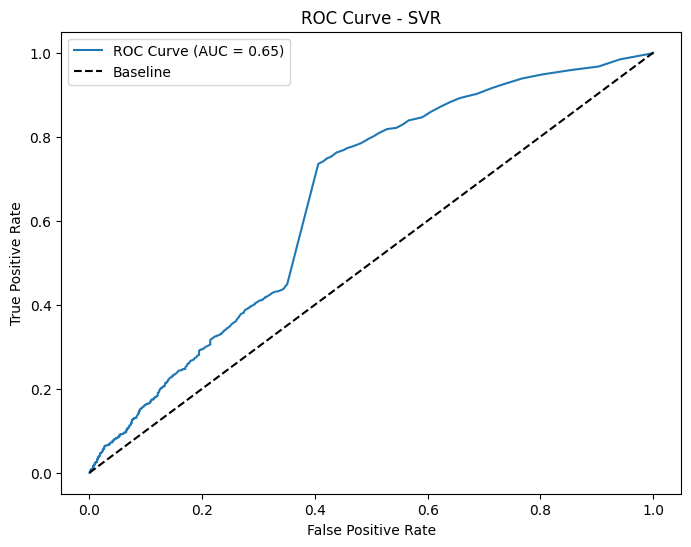

In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Membuat sesi Spark
spark = SparkSession.builder.appName("GamePopularityEstimation").getOrCreate()

# Load dataset yang telah diproses (pastikan path sesuai)
file_path = "/content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Menampilkan beberapa baris data
data.show(5)

# Mengecek schema data untuk memastikan tipe datanya sesuai
data.printSchema()

# Memilih fitur (user_score dan user_rating_count) dan target (popularitas)
features = ['User Ratings Count']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Memisahkan dataset menjadi training dan testing set (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="User Score", numTrees=100, maxDepth=5, seed=42)
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

# Evaluasi model Random Forest
rmse_evaluator = RegressionEvaluator(labelCol="User Score", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="User Score", predictionCol="prediction", metricName="r2")
rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Random Forest Regressor - Root Mean Squared Error (RMSE): {rmse}")
print(f"Random Forest Regressor - R-squared (R2): {r2}")

# Menyimpan model
model_path = "/content/drive/My Drive/dataset-ai/vector_regressor_model"
rf_model.save(model_path)
print(f"Model telah disimpan ke: {model_path}")

# Support Vector Regressor (SVR)
# Konversi data PySpark ke Pandas
pandas_data = data.select("User Ratings Count", "User Score").toPandas()

# Membagi fitur dan target
X = pandas_data[["User Ratings Count"]].values
y = pandas_data["User Score"].values

# Binarisasi target untuk evaluasi klasifikasi
threshold = 7.0
y_binarized = (y > threshold).astype(int)

# Membagi data menjadi training dan testing set (80% training, 20% testing)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

# Standarisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Inisialisasi Support Vector Regressor
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)

# Prediksi dengan SVR
y_pred = svr.predict(X_test)
y_pred_binarized = (y_pred > 0.5).astype(int)

# Evaluasi metrik regresi
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_svr = r2_score(y_test, y_pred)

print(f"Support Vector Regressor - Root Mean Squared Error (RMSE): {rmse_svr}")
print(f"Support Vector Regressor - R-squared (R2): {r2_svr}")

# Evaluasi metrik klasifikasi
accuracy = accuracy_score(y_test, y_pred_binarized)
f1 = f1_score(y_test, y_pred_binarized)
precision = precision_score(y_test, y_pred_binarized)
recall = recall_score(y_test, y_pred_binarized)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Support Vector Regressor - Akurasi: {accuracy:.2f}")
print(f"Support Vector Regressor - F1 Score: {f1:.2f}")
print(f"Support Vector Regressor - Presisi: {precision:.2f}")
print(f"Support Vector Regressor - Recall: {recall:.2f}")
print(f"Support Vector Regressor - AUC (ROC Curve): {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVR")
plt.legend()
plt.show()


+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|               Title|Release Date|           Developer|      Publisher|         Genres|      Product Rating|User Score|User Ratings Count|      Platforms Info|
+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|     Ziggurat (2012)|   2/17/2012|Action Button Ent...|   Freshuu Inc.|         Action|    Rated T For Teen|       6.9|              14.0|[{'Platform': 'iO...|
|           4X4 EVO 2|  11/15/2001|    Terminal Reality|      Gathering|Auto Racing Sim|Rated E For Everyone|       7.2|              34.0|[{'Platform': 'Xb...|
|     MotoGP 2 (2001)|   1/22/2002|               Namco|          Namco|Auto Racing Sim|Rated E For Everyone|       5.8|              34.0|[{'Platform': 'Pl...|
|            Gothic 3|  11/14/2006

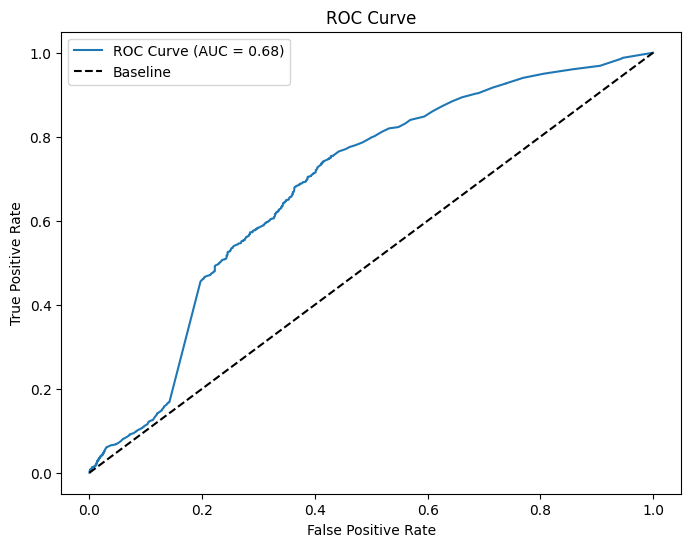

Model telah disimpan ke: /content/drive/My Drive/dataset-ai/neural_network_model.keras


In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Membuat sesi Spark
spark = SparkSession.builder.appName("GamePopularityEstimation").getOrCreate()

# Load dataset
file_path = "/content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Menampilkan beberapa baris data
data.show(5)

# Mengecek schema data
data.printSchema()

# Memilih fitur (user_rating_count) dan target (user_score)
features = ['User Ratings Count']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Konversi Spark DataFrame ke Pandas DataFrame
pandas_data = data.select("User Ratings Count", "User Score").toPandas()

# Memisahkan fitur dan target
X = pandas_data[["User Ratings Count"]].values
y = pandas_data["User Score"].values

# Binarisasi target untuk klasifikasi
# Contoh: User Score > 7 dianggap "populer" (label 1), lainnya "tidak populer" (label 0)
threshold = 7.0
y_binarized = (y > threshold).astype(int)

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized, test_size=0.2, random_state=42)

# Standarisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural Network dengan TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer untuk klasifikasi biner
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Membuat prediksi
y_pred_proba = model.predict(X_test).flatten()  # Probabilitas prediksi
y_pred = (y_pred_proba > 0.5).astype(int)  # Thresholding untuk prediksi label

# Menghitung metrik
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Menampilkan hasil metrik
print(f"Akurasi: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC (ROC Curve): {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Menyimpan model TensorFlow
model_path = "/content/drive/My Drive/dataset-ai/neural_network_model.keras"
model.save(model_path)
print(f"Model telah disimpan ke: {model_path}")


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, col
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

# Membuat sesi Spark
spark = SparkSession.builder.appName("GamePopularityEstimation").getOrCreate()

# Load dataset yang telah diproses
file_path = "/content/drive/My Drive/dataset-ai/all_video_games_preprocessed.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True)

# Menampilkan beberapa baris data
data.show(5)
data.printSchema()

# Memilih fitur (user_score dan user_rating_count) dan target (User Score)
target_col = "User Score"
features = ['User Ratings Count']
assembler = VectorAssembler(inputCols=features, outputCol="features")
data = assembler.transform(data)

# Mengubah target menjadi kategori: "Populer" (>7.0) atau "Tidak Populer" (≤7.0)
data = data.withColumn("popular", when(col(target_col) > 7.0, 1).otherwise(0))

# Memisahkan dataset menjadi training dan testing set (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Inisialisasi Gradient Boosted Tree Regressor
gbt = GBTRegressor(featuresCol="features", labelCol=target_col, maxIter=100, maxDepth=5, seed=42)

# Melatih model
gbt_model = gbt.fit(train_data)

# Membuat prediksi pada testing set
predictions = gbt_model.transform(test_data)

# Menampilkan beberapa prediksi
predictions.select("features", target_col, "prediction").show(5)

# Evaluasi Regresi
rmse_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")

rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Gradient Boosted Tree Regressor - Root Mean Squared Error (RMSE): {rmse}")
print(f"Gradient Boosted Tree Regressor - R-squared (R2): {r2}")

# Konversi Prediksi menjadi kategori
predictions = predictions.withColumn("predicted_popular", when(col("prediction") > 7.0, 1).otherwise(0))

# Evaluasi Klasifikasi
pandas_predictions = predictions.select("popular", "predicted_popular").toPandas()
y_true = pandas_predictions["popular"]
y_pred = pandas_predictions["predicted_popular"]

auc = roc_auc_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"AUC (ROC): {auc}")
print(f"Akurasi: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Presisi: {precision}")
print(f"Recall: {recall}")

# Menyimpan model
model_path = "/content/drive/My Drive/dataset-ai/gbt_model"
gbt_model.save(model_path)
print(f"Model telah disimpan ke: {model_path}")


+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|               Title|Release Date|           Developer|      Publisher|         Genres|      Product Rating|User Score|User Ratings Count|      Platforms Info|
+--------------------+------------+--------------------+---------------+---------------+--------------------+----------+------------------+--------------------+
|     Ziggurat (2012)|   2/17/2012|Action Button Ent...|   Freshuu Inc.|         Action|    Rated T For Teen|       6.9|              14.0|[{'Platform': 'iO...|
|           4X4 EVO 2|  11/15/2001|    Terminal Reality|      Gathering|Auto Racing Sim|Rated E For Everyone|       7.2|              34.0|[{'Platform': 'Xb...|
|     MotoGP 2 (2001)|   1/22/2002|               Namco|          Namco|Auto Racing Sim|Rated E For Everyone|       5.8|              34.0|[{'Platform': 'Pl...|
|            Gothic 3|  11/14/2006

## **Hyperparameter Tuning**

+--------+----------+----------------+
|features|User Score|      prediction|
+--------+----------+----------------+
|  [34.0]|       7.2|7.02513616712002|
|  [34.0]|       7.2|7.02513616712002|
|  [34.0]|       7.2|7.02513616712002|
|  [34.0]|       7.2|7.02513616712002|
|  [34.0]|       7.2|7.02513616712002|
+--------+----------+----------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) after tuning: 1.2521812909547942
R-squared (R2) after tuning: 0.054742711328616966
Akurasi: 0.68
F1 Score: 0.73
Presisi: 0.74
Recall: 0.72
AUC (ROC Curve): 0.66


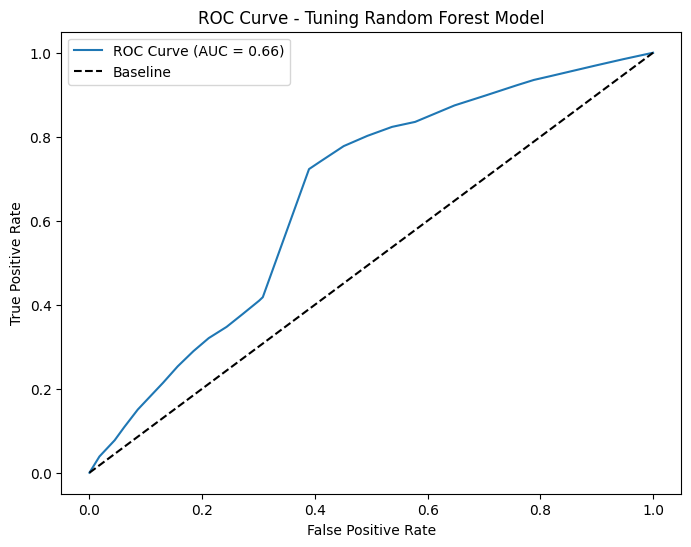

Model terbaik setelah tuning telah disimpan ke: /content/drive/My Drive/dataset-ai/random_forest_model_tuned


In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Menyiapkan evaluator untuk mengukur performa model
rmse_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")

# Menyiapkan grid parameter untuk tuning
param_grid = (ParamGridBuilder()
              .addGrid(rf.numTrees, [50, 100, 200])  # Jumlah pohon dalam Random Forest
              .addGrid(rf.maxDepth, [3, 5, 10])  # Kedalaman maksimal pohon
              .addGrid(rf.maxBins, [32, 64])  # Jumlah bins untuk pemisahan data
              .build())

# Menyiapkan CrossValidator dengan evaluasi RMSE dan R²
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=rmse_evaluator,
                          numFolds=3,  # Menentukan jumlah fold cross-validation
                          parallelism=2)  # Mengatur jumlah pekerjaan paralel

# Melatih model dengan CrossValidator
cv_model = crossval.fit(train_data)

# Mendapatkan model terbaik setelah tuning
best_model = cv_model.bestModel

# Membuat prediksi menggunakan model terbaik
predictions = best_model.transform(test_data)

# Menampilkan beberapa prediksi
predictions.select("features", target_col, "prediction").show(5)

# Evaluasi model terbaik menggunakan RMSE dan R²
rmse = rmse_evaluator.evaluate(predictions)
r2 = r2_evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) after tuning: {rmse}")
print(f"R-squared (R2) after tuning: {r2}")

# Evaluasi klasifikasi dengan threshold untuk binarisasi
pandas_predictions = predictions.select("User Score", "prediction").toPandas()
threshold = 7.0  # Contoh threshold untuk binarisasi
y_true = (pandas_predictions["User Score"] > threshold).astype(int)
y_pred = (pandas_predictions["prediction"] > threshold).astype(int)

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, pandas_predictions["prediction"])

print(f"Akurasi: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Presisi: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"AUC (ROC Curve): {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, pandas_predictions["prediction"])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuning Random Forest Model")
plt.legend()
plt.show()

# Menyimpan model terbaik
model_path = "/content/drive/My Drive/dataset-ai/random_forest_model_tuned"
best_model.save(model_path)
print(f"Model terbaik setelah tuning telah disimpan ke: {model_path}")


In [18]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.4 MB/s eta 0:00:00


Trial 60 Complete [00h 00m 13s]
val_accuracy: 0.6714094877243042

Best val_accuracy So Far: 0.6758559346199036
Total elapsed time: 00h 07m 12s
Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6513 - loss: 0.6417 - val_accuracy: 0.6092 - val_loss: 0.6457
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6648 - loss: 0.6271 - val_accuracy: 0.6732 - val_loss: 0.6412
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6560 - loss: 0.6370 - val_accuracy: 0.6719 - val_loss: 0.6615
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6655 - loss: 0.6269 - val_accuracy: 0.6665 - val_loss: 0.6273
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6786 - loss: 0.6178 - val_accuracy: 0.6723 - val_loss: 0.6228
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6839 - loss: 0.6154 - val_accuracy: 0.6750 - val_loss: 0.6363
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6620 - loss: 0.6322 - v

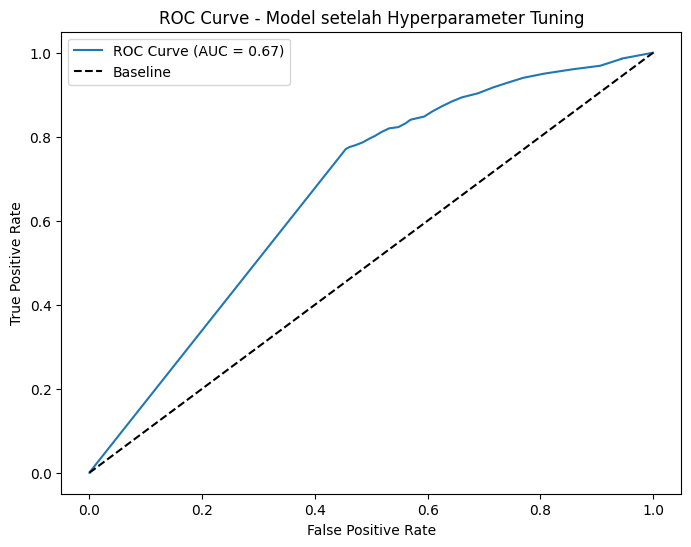

Model terbaik setelah tuning telah disimpan ke: /content/drive/My Drive/dataset-ai/neural_network_model_tuned.keras


In [20]:
import tensorflow as tf
import keras_tuner as kt

# Fungsi model yang akan digunakan oleh Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()

    # Menambahkan input layer
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    # Menambahkan hidden layers dengan jumlah unit yang dapat dipilih
    model.add(tf.keras.layers.Dense(
        hp.Int('units_1', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    model.add(tf.keras.layers.Dense(
        hp.Int('units_2', min_value=32, max_value=128, step=32),
        activation='relu'
    ))

    # Output layer dengan sigmoid untuk klasifikasi biner
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Menentukan optimizer dan laju pembelajaran (learning rate)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Menggunakan Keras Tuner untuk mencari hyperparameter terbaik
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  # Metrik yang digunakan untuk evaluasi (validation accuracy)
    max_epochs=10,
    hyperband_iterations=2,
    directory='/content/drive/My Drive/dataset-ai/tuner',
    project_name='game_popularity_tuning'
)

# Melatih model menggunakan hyperparameter tuning
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Mendapatkan model terbaik setelah tuning
best_model = tuner.get_best_models(num_models=1)[0]

# Melatih model terbaik
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Membuat prediksi menggunakan model terbaik
y_pred_proba = best_model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Menampilkan hasil metrik
print(f"Akurasi setelah tuning: {accuracy:.2f}")
print(f"F1 Score setelah tuning: {f1:.2f}")
print(f"Presisi setelah tuning: {precision:.2f}")
print(f"Recall setelah tuning: {recall:.2f}")
print(f"AUC (ROC Curve) setelah tuning: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model setelah Hyperparameter Tuning")
plt.legend()
plt.show()

# Menyimpan model terbaik setelah tuning
best_model_path = "/content/drive/My Drive/dataset-ai/neural_network_model_tuned.keras"
best_model.save(best_model_path)
print(f"Model terbaik setelah tuning telah disimpan ke: {best_model_path}")
